# Generative Adversarial Network (GAN)

## Concept

GAN is composed of two neural networks that compete with each other, hence the name adversarial. There's the **Generator** network (G) and **Discriminator** network (D).

### Generator Network

The generator's task is to generate _fake data_ that could, hopefully, fool the discriminator. The generator does not have access to the _real data_ that the discriminator expects, instead it improves its ability to generate fake data by learning what feature of the data is expected by the discriminator.

- Input: vector of **noise**
- Output: fake data with the **same shape** as the real data

Stochastic gradient for generator network:

<center> $\bigtriangledown_{\theta_{d}}\frac{1}{m} \displaystyle\sum_{i=1}^{m}log (1-D(G(z^{(i)})))$ </center>

The target is to **minimize** the value of $1-D(G(z^{(i)}))$ which means **maximizing** the value of $D(G(z^{(i)})$, the probability that the discriminator passes the fake data generated by the generator as real.

### Discriminator Network

The discriminator's task is to determine if a data is _real_ or _fake_.

- Input: real and fake **data**
- Output: binary (is the data real or fake)

Stochastic gradient for discriminator network:

<center> $\bigtriangledown_{\theta_{d}}\frac{1}{m} \displaystyle\sum_{i=1}^{m}[log D(x^{(i)}) + log (1-D(G(z^{(i)})))]$ </center>

## GAN for MNIST Dataset with Keras

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import random
import sys

import keras.backend as K

from functools import partial
from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.merge import _Merge
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical

In [2]:
class GAN():
    
    def __init__(self):
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        self.noise_shape = (100,)

        # Manually tune down learning rate to avoid oscillation
        optimizer = Adam(lr=0.0002, beta_1=0.5)

        # -------------
        # Discriminator
        # -------------
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mean_squared_error', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        # ---------
        # Generator
        # ---------
        self.generator = self.build_generator()
        self.generator.compile(loss='mean_squared_error',
                               optimizer=optimizer)
        # --------
        # Combined
        # --------
        # The combined model is created by stacking generator and discriminator.
        # Noise ---Generator--> Generated Image ---Discriminator--> Validity
        
        z = Input(shape=self.noise_shape)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        validity = self.discriminator(img)

        self.combined = Model(z, validity)
        self.combined.compile(loss='mean_squared_error',
                              optimizer=optimizer)

        
    def save_model(self, version=None):
        if version is None:
            self.discriminator.save('gan/models/mnist-discriminator.h5')
            self.generator.save('gan/models/mnist-generator.h5')
            self.combined.save('gan/models/mnist-combined.h5')
        else:
            self.discriminator.save('gan/models/mnist-discriminator-{}.h5'.format(version))
            self.generator.save('gan/models/mnist-generator-{}.h5'.format(version))
            self.combined.save('gan/models/mnist-combined-{}.h5'.format(version))
        
        
    def load_model(self, version=None): 
        if version is None:
            self.discriminator = load_model('gan/models/mnist-discriminator.h5')
            self.generator = load_model('gan/models/mnist-generator.h5')
            self.combined = load_model('gan/models/mnist-combined.h5')
        else:
            self.discriminator = load_model('gan/models/mnist-discriminator-{}.h5'.format(version))
            self.generator = load_model('gan/models/mnist-generator-{}.h5'.format(version))
            self.combined = load_model('gan/models/mnist-combined-{}.h5'.format(version))
            
        
    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        # Discriminator takes an image as an input and outputs its validity
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

        
    def build_generator(self):
        # BatchNormalization maintains the mean activation close to 0
        # and the activation standard deviation close to 1
        model = Sequential()
        model.add(Dense(256, input_shape=self.noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='sigmoid'))
        model.add(Reshape(self.img_shape))
        
        model.summary()

        # Generator takes noise as an input and outputs an image
        noise = Input(shape=self.noise_shape)
        img = model(noise)

        return Model(noise, img)
    
    
    def train(self, epochs, batch_size=128, export_interval=250, save_model_interval=5000):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()        
        # X_train shape: (m, W, H)
        
        X_train = X_train[:40000]
        X_train = (X_train.astype(np.float32)) / 255
        
        # Change X_train's shape to (m, W, H, c)
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # -------------------
            # Train Discriminator
            # -------------------
            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # Generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 100))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------
            # Train Generator
            # ---------------
            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants to fool the discriminator, hence trained with valid label (1)
            # valid_y = np.array([1] * batch_size)
            valid_y = np.ones((batch_size, 1))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)


            # Print progress
            print ("{:5d} [D loss: {}, acc_real: {:2f}, acc_fake: {:2f}] [G loss: {}]".format(epoch, d_loss[0], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss))

            with open('gan/logs/gan.log', 'a') as log_file:
                log_file.write('{},{}\n'.format(d_loss[0], g_loss))
            
            # Save generated samples at export_interval
            if epoch % export_interval == 0:
                r, c = 3, 3

                fig, axs = plt.subplots(r, c)
                
                prediction = self.discriminator.predict(gen_imgs)
                prediction = np.round(prediction)
                
                fooled_indices = []
                
                for i in range(len(prediction)):
                    if prediction[i] == 1:
                        fooled_indices.append(i)
                
                fooled_count = len(fooled_indices)
                
                # Export generated images that the discriminator classified as real
                cnt = 0
                if (fooled_count > 0):
                    for i in range(r):
                        for j in range(c):
                            if (cnt >= fooled_count):
                                break
                            axs[i,j].imshow(gen_imgs[fooled_indices[cnt], :,:,0], cmap='gray')
                            axs[i,j].axis('off')
                            cnt += 1
                            
                fig.savefig("gan/images/mnist_{}_fooled.png".format(epoch))
                plt.close()
                
                # Export generated images that the discriminator classified as fake
                fig, axs = plt.subplots(r, c)
                success_count = len(prediction) - fooled_count
                cnt = 0
                if (success_count > 0):
                    for i in range(r):
                        for j in range(c):
                            while cnt in fooled_indices:
                                cnt += 1
                            if (cnt >= success_count):
                                break
                            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                            axs[i,j].axis('off')
                            cnt += 1
                fig.savefig("gan/images/mnist_{}_detected.png".format(epoch))
                plt.close()
            
            # Save models at save_interval
            if epoch != 0 and epoch % save_model_interval == 0:
                self.save_model(version=str(epoch))
                

# if __name__ == '__main__':
#     gan = GAN()
#     gan.train(epochs=30001, batch_size=64, export_interval=1000, save_model_interval=10000)

### Loading Saved GAN Model

In [3]:
gan_mse = GAN()
gan_mse.load_model(version='mse')

gan_bce = GAN()
gan_bce.load_model(version='bce')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/home/rionaldichandraseta/miniconda3/envs/gan-keras/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

### Comparing GAN models with MSE and BCE

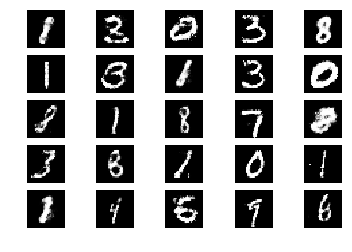

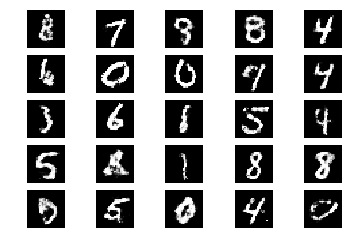

In [4]:
noise = np.random.normal(0, 1, (25, 100))

gen_imgs_mse = gan_mse.generator.predict(noise)
gen_imgs_bce = gan_bce.generator.predict(noise)

fig, axs = plt.subplots(5, 5)
count = 0
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(gen_imgs_mse[count, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        count += 1
        
fig, axs = plt.subplots(5, 5)
count = 0
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(gen_imgs_bce[count, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        count += 1

## Build MNIST Classifier

In [5]:
def get_processed_dataset(n_train, n_test, n_class):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
        # Shapes:
        #   x_train, x_test = (m, W, H)
        #   y_train, y_test = (m)

    x_train = np.expand_dims(x_train, axis=3)
    x_test = np.expand_dims(x_test, axis=3)
        # Shapes:
        #   x_train, x_test = (m, W, H, c)

    # Get normalized training data
    data_per_class = n_train / n_class
    count = np.zeros(10)
    new_x_train = np.empty_like(x_train)
    new_y_train = np.empty_like(y_train)
    new_x_train = new_x_train[:n_train]
    new_y_train = new_y_train[:n_train]
    it = 0
    for idx, label in enumerate(y_train):
        if count[label] >= data_per_class:
            pass
        else:
            new_x_train[it] = x_train[idx]
            new_y_train[it] = y_train[idx]
            count[label] += 1
            it += 1
            
    # Get normalized testing data
    data_per_class = n_test / n_class
    count = np.zeros(10)
    new_x_test = np.empty_like(x_test)
    new_y_test = np.empty_like(y_test)
    new_x_test = new_x_test[:n_test]
    new_y_test = new_y_test[:n_test]
    it = 0
    for idx, label in enumerate(y_test):
        if count[label] >= data_per_class:
            pass
        else:
            new_x_test[it] = x_test[idx]
            new_y_test[it] = y_test[idx]
            count[label] += 1
            it += 1
            
    new_x_train = new_x_train.astype('float32')
    new_x_test = new_x_test.astype('float32')

    new_x_train /= 255
    new_x_test /= 255
    
    new_y_train = to_categorical(new_y_train, n_class)
    new_y_test = to_categorical(new_y_test, n_class)
    
    return (new_x_train, new_y_train), (new_x_test, new_y_test)

In [6]:
class MNISTClassifier():
    
    def __init__(self):
        self.n_class = 10
        
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channel)
        
        adam = Adam(lr=0.001,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=None,
                    decay=0.00001,
                    amsgrad=False)
        
        self.classifier = self.build_classifier()
        self.classifier.compile(optimizer=adam,
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

    def save_model(self, version=None):
        if version is None:
            self.classifier.save('gan/models/mnist-classifier.h5')
        else:
            self.classifier.save('gan/models/mnist-classifier-{}.h5'.format(version))
            
    
    def load_model(self, version=None):
        if version is None:
            self.classifier = load_model('gan/models/mnist-classifier.h5')
        else:
            self.classifier = load_model('gan/models/mnist-classifier-{}.h5'.format(version))
        
        
    def build_classifier(self):
        model = Sequential()
        model.add(Conv2D(32,
                         kernel_size=(3,3),
                         activation='relu',
                         input_shape=self.img_shape,
                         data_format='channels_last'))
        model.add(Conv2D(64,
                         kernel_size=(3,3),
                         activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128,
                        activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(self.n_class,
                        activation='softmax'))
        
        model.summary()
        
        return model
    
    def train(self, batch_size=400, epoch_limit=50, n_train=40000, version='conv'):
        n_train = n_train if n_train > 0 and n_train <= 60000 else 60000
        
        (x_train, y_train), (x_test, y_test) = get_processed_dataset(n_train, 10000, self.n_class)
        
        # --------
        # Training
        # --------

        history = self.classifier.fit(x_train, y_train,
                                     batch_size=batch_size,
                                     epochs=epoch_limit,
                                     verbose=1,
                                     validation_data=(x_test, y_test))

        self.save_model(version)
        
    def train_on_original_dataset(self, version='conv-full'):
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        
        x_train = np.expand_dims(x_train, axis=3)
        x_test = np.expand_dims(x_test, axis=3)
        
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')

        x_train /= 255
        x_test /= 255

        y_train = to_categorical(y_train, n_class)
        y_test = to_categorical(y_test, n_class)
        
        # --------
        # Training
        # --------
        
        history = self.classifier.fit(x_train, y_train,
                                     batch_size=600,
                                     epochs=50,
                                     verbose=1,
                                     validation_data=(x_test, y_test))

        self.save_model(version)
        
    def train_on_custom_dataset(self, x_train, y_train, batch_size=500, epoch_limit=50, version='conv-with-gan'):
        (_, _), (x_test, y_test) = get_processed_dataset(0, 10000, self.n_class)
        
        # --------
        # Training
        # --------
        
        history = self.classifier.fit(x_train, y_train,
                                      batch_size=batch_size,
                                      epochs=epoch_limit,
                                      verbose=1,
                                      validation_data=(x_test, y_test))
        
        self.save_model(version)

        
    def evaluate(self, n_test=9000):
        (x_train, y_train), (x_test, y_test) = get_processed_dataset(0, n_test, self.n_class)
        
        score = self.classifier.evaluate(x_test, y_test,
                                         verbose=1)
        print('Test Loss = {}, Test Accuracy = {}'.format(score[0], score[1]))
        
# if __name__ == '__main__':
#     conv = MNISTClassifier()
#     conv.train(epoch_limit=50)

## Export Generated Dataset (Image + Label)

In [7]:
def save_gen_data(gen_imgs, labels, file_name=None):
    file_name = file_name if file_name is not None else 'gen_imgs'
    path = 'gan/gen-images/'
    file_name = path + file_name
    file_name_x = file_name + '_x'
    file_name_y = file_name + '_y'
    
    np.save(file_name_x, gen_imgs)
    np.save(file_name_y, labels)
    
def load_gen_data(file_name):
    path = 'gan/gen-images/'
    file_name = path + file_name
    file_name_x = file_name + '_x.npy'
    file_name_y = file_name + '_y.npy'
    
    gen_imgs = np.load(file_name_x)
    labels = np.load(file_name_y)
    return (gen_imgs, labels)

if __name__ == '__main__':
    noise = np.random.normal(0, 1, (30000, 100))

    gen_imgs = gan_bce.generator.predict(noise)

    conv = MNISTClassifier()
    conv.load_model('conv')
    predictions = conv.classifier.predict(gen_imgs)

    save_gen_data(gen_imgs, predictions, file_name='bce')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [8]:
conv = MNISTClassifier()
conv.load_model('conv')

conv.evaluate()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

The model achieves 98.83% on the test set after training with the reduced original dataset

## Analyze Generated Data

In [9]:
(gen_imgs, labels) = load_gen_data(file_name='bce')

labels_clone = labels
threshold = 0.99999
labels_clone = np.where(labels > threshold, 1, 0)

# Number of MNIST class
n_class = 10

below_threshold_indices = []
below_threshold_count = 0
for i in range (len(labels_clone)):
    all_zero = True
    for j in range (n_class):
        if all_zero:
            all_zero = labels_clone[i][j] == 0
        else:
            break
    if all_zero:
        below_threshold_count += 1
        below_threshold_indices.append(i)

print('Detected {} generated data that falls below the threshold of {}'.format(below_threshold_count, threshold))

failed_counts = np.zeros(10)
for index in below_threshold_indices:
    failed_counts[np.argmax(labels[index])] += 1
    
print('Label distribution for data below threshold: {}'.format(failed_counts))

above_threshold_indices = []
success_counts = np.zeros(10)
for idx, label in enumerate(labels):
    if idx not in below_threshold_indices:
        success_counts[np.argmax(label)] += 1
        above_threshold_indices.append(idx)
    
print('Label distribution for data above threshold: {}'.format(success_counts))

Detected 11208 generated data that falls below the threshold of 0.99999
Label distribution for data below threshold: [ 778.  769. 1091. 1340.  956. 1285.  864. 1164. 1336. 1625.]
Label distribution for data above threshold: [2084. 2662. 1013. 2119. 1717. 1903. 1736. 2498. 1409. 1651.]


### Samples of Data Below Threshold

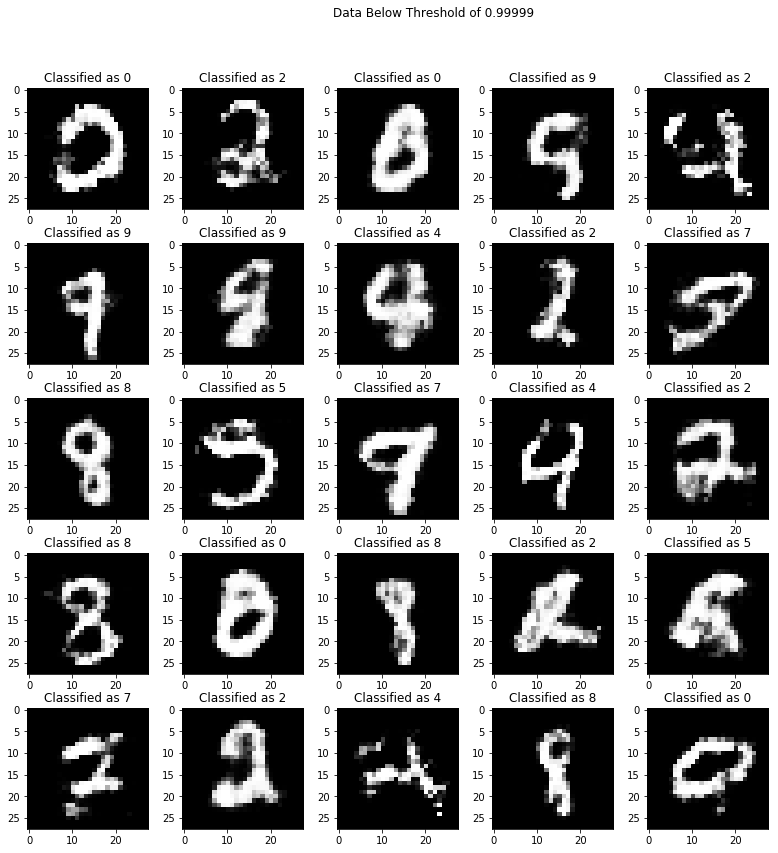

In [10]:
figure, ax = plt.subplots(5,5, figsize=(12, 12))
figure.suptitle('Data Below Threshold of {}'.format(threshold))
figure.tight_layout(pad=0.3, rect=[0,0,0.9,0.9])

used_indices = []
for x, y in [(i, j) for i in range(5) for j in range(5)]:
    index = random.choice(below_threshold_indices)
    while index in used_indices:
        index = random.choice(below_threshold_indices)
    used_indices.append(index)
    # Check if the randomized index has been used this time
    ax[x, y].imshow(gen_imgs[index].reshape((28,28)), cmap='gray')
    ax[x, y].set_title('Classified as {}'.format(np.argmax(labels[index])))

### Samples of Data Above Threshold

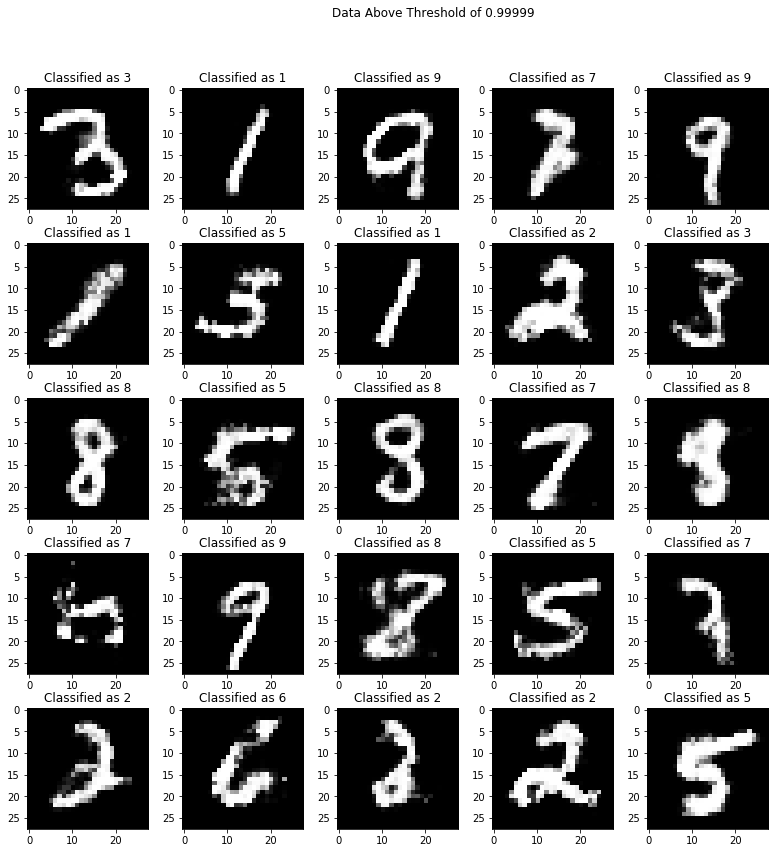

In [11]:
figure, ax = plt.subplots(5,5, figsize=(12, 12))
figure.suptitle('Data Above Threshold of {}'.format(threshold))
figure.tight_layout(pad=0.3, rect=[0,0,0.9,0.9])

used_indices = []
for x, y in [(i, j) for i in range(5) for j in range(5)]:
    index = random.randint(0,len(labels))
    # Check if the randomized index has been used this time
    while index not in range(len(labels)):        
        while index in used_indices or index in failed_indices:
            index += 1
        if index >= len(labels):
            index = random.randint(0,len(labels))
    used_indices.append(index)
    ax[x, y].imshow(gen_imgs[index].reshape((28,28)), cmap='gray')
    ax[x, y].set_title('Classified as {}'.format(np.argmax(labels[index])))

### Concatenate Generated Data to Original Dataset

In [12]:
def normalize_data(x_train, y_train, above_threshold_indices, n_train=10000, n_class=10):
    # Shapes:
    #   x_train = (m, W, H, c)
    #   y_train = (m)
    
    # Get normalized training data
    data_per_class = n_train / n_class
    count = np.zeros(10)
    new_x_train = np.empty_like(x_train)
    new_y_train = np.empty_like(y_train)
    new_x_train = new_x_train[:n_train]
    new_y_train = new_y_train[:n_train]
    it = 0
    for idx in above_threshold_indices:
        if count[int(y_train[idx])] >= data_per_class:
            pass
        else:
            new_x_train[it] = x_train[idx]
            new_y_train[it] = y_train[idx]
            count[int(y_train[idx])] += 1
            it += 1
            
    new_x_train = new_x_train.astype('float32')
    new_x_train /= 255
    new_y_train = to_categorical(new_y_train, n_class)
    
    return (new_x_train, new_y_train)

In [13]:
(gen_imgs, predictions) = load_gen_data(file_name='bce')


# Find indices of data below and above threshold

labels_clone = predictions
threshold = 0.999
labels_clone = np.where(labels_clone > threshold, 1, 0)

below_threshold_indices = []
below_threshold_count = 0
for i in range (len(labels_clone)):
    all_zero = True
    for j in range (n_class):
        if all_zero:
            all_zero = labels_clone[i][j] == 0
        else:
            break
    if all_zero:
        below_threshold_count += 1
        below_threshold_indices.append(i)

above_threshold_indices = []
success_counts = np.zeros(10)
for idx, label in enumerate(labels_clone):
    if idx not in below_threshold_indices:
        success_counts[np.argmax(label)] += 1
        above_threshold_indices.append(idx)


# Convert to labels for processing

labels = np.empty((len(predictions)))
for idx, prediction in enumerate(predictions):
    labels[idx] = np.argmax(predictions[idx])

(new_x_train, new_y_train) = normalize_data(gen_imgs, labels, above_threshold_indices)

labels = np.empty((len(new_y_train)))
for idx, label in enumerate(new_y_train):
    labels[idx] = np.argmax(label)

count = np.zeros(10)
for label in labels:
    count[int(label)] += 1
    
print('Generated data distribution:\n{}'.format(count))

Generated data distribution:
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]


In [14]:
# (x_train, y_train), (_, _) = get_processed_dataset(40000, 0, 10)

# x_train = np.concatenate((x_train, new_x_train), axis=0)
# y_train = np.concatenate((y_train, new_y_train), axis=0)

# new_conv = MNISTClassifier()
# new_conv.train_on_custom_dataset(x_train, y_train, version='conv-with-gan-bce')

In [15]:
new_conv_bce = MNISTClassifier()
new_conv_bce.load_model('conv-with-gan-bce')

new_conv_bce.evaluate()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

Accuracy of the model increased from 98.83% to 98.88%, an increase of 5 more correct samples.

In [16]:
new_conv_mse = MNISTClassifier()
new_conv_mse.load_model('conv-with-gan-mse')

new_conv_mse.evaluate()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

Accuracy of the model increased from 98.83% to 98.97%, an increase of 14 more correct samples

## Comparison with Original Dataset

In [17]:
# full_conv = MNISTClassifier()
# full_conv.train_on_original_dataset()

In [18]:
new_conv = MNISTClassifier()
new_conv.load_model('conv-full')

new_conv.evaluate()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
__________

Accuracy of the model with full original dataset is 99.26%, marginally higher than the model with GAN-expanded dataset.

## WGAN-GP

In [37]:
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(100,))
        # Generate image based of noise (fake sample)
        fake_img = self.generator(z_disc)

        # Discriminator determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # Generate images based of noise
        img = self.generator(z_gen)
        # Discriminator determines validity
        valid = self.critic(img)
        # Defines generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)

        
    def save_model(self, version=None):
        if version is None:
            self.generator.save('gan/models/mnist-wgan-gp-generator.h5')
            self.critic.save('gan/models/mnist-wgan-gp-critic.h5')
            # self.generator_model.save('gan/models/mnist-wgan-gp-generator-model.h5')
        else:
            self.generator.save('gan/models/mnist-wgan-gp-generator-{}.h5'.format(version))
            self.critic.save('gan/models/mnist-wgan-gp-critic-{}.h5'.format(version))
            # self.generator_model.save('gan/models/mnist-wgan-gp-generator-model-{}.h5'.format(version))
        
        
    def load_model(self, version=None): 
        if version is None:
            self.generator = load_model('gan/models/mnist-wgan-gp-generator.h5')
            self.critic = load_model('gan/models/mnist-wgan-gp-critic.h5')
            # self.generator_model = load_model('gan/models/mnist-wgan-gp-generator-model.h5')
        else:
            self.generator = load_model('gan/models/mnist-wgan-gp-generator-{}.h5'.format(version))
            self.critic = load_model('gan/models/mnist-wgan-gp-critic-{}.h5'.format(version))
            # self.generator_model = load_model('gan/models/mnist-wgan-gp-generator-model-{}.h5'.format(version))
            
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size, sample_interval=500, save_model_interval=1000):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, noise],
                                                                [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.generator_model.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
            
            with open('gan/logs/wgan_gp.log', 'a') as log_file:
                log_file.write('{},{}\n'.format(d_loss[0], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                
            if epoch % save_model_interval == 0:
                self.save_model(version=str(epoch))
                
            

    def sample_images(self, epoch):
        r, c = 3, 3
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("gan/images/wgan_mnist_%d.png" % epoch)
        plt.close()

In [36]:
# if __name__ == '__main__':
#     wgan = WGANGP()
#     wgan.train(epochs=30001, batch_size=32, sample_interval=10, save_model_interval=1000)

In [ ]:
load_wgan = WGANGP()
load_wgan.load_model('0')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_10 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_13 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_37 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
activation_19 (Activation)   (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 28, 28, 128)       0         
__________